<a href="https://colab.research.google.com/github/Kiedroo12/Finanse/blob/main/modelowanie_zmiennosci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install yfinance arch statsmodels scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 4.9 MB/s eta 0:00:00


In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import yfinance as yf

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from scipy.stats import jarque_bera
import matplotlib.dates as mdates

In [7]:
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = None
ANNUALIZATION = 252

raw = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=False,
    progress=False
)

if raw.empty:
    raise RuntimeError("Brak danych — sprawdź ticker lub zakres dat")

df = raw.copy()

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = [c.replace(" ", "_") for c in df.columns]

if "Adj_Close" not in df.columns:
    raise RuntimeError("Brak kolumny Adj_Close")

df["log_ret"] = 100 * np.log(df["Adj_Close"]).diff()

df = df.dropna().copy()

print(f"Zakres danych: {df.index.min().date()} → {df.index.max().date()}")
print(f"Liczba obserwacji: {len(df)}")

df.head()


Zakres danych: 2010-01-05 → 2025-12-16
Liczba obserwacji: 4013


,Adj_Close,Close,High,Low,Open,Volume,log_ret
Date,,,,,,,
2010-01-05,6.429480,7.656429,7.699643,7.616071,7.664286,601904800,0.172751
2010-01-06,6.327211,7.534643,7.686786,7.526786,7.656429,552160000,-1.603408
2010-01-07,6.315515,7.520714,7.571429,7.466071,7.562500,477131200,-0.185029
2010-01-08,6.357502,7.570714,7.571429,7.466429,7.510714,447610800,0.662622
2010-01-11,6.301419,7.503929,7.607143,7.444643,7.600000,462229600,-0.886064


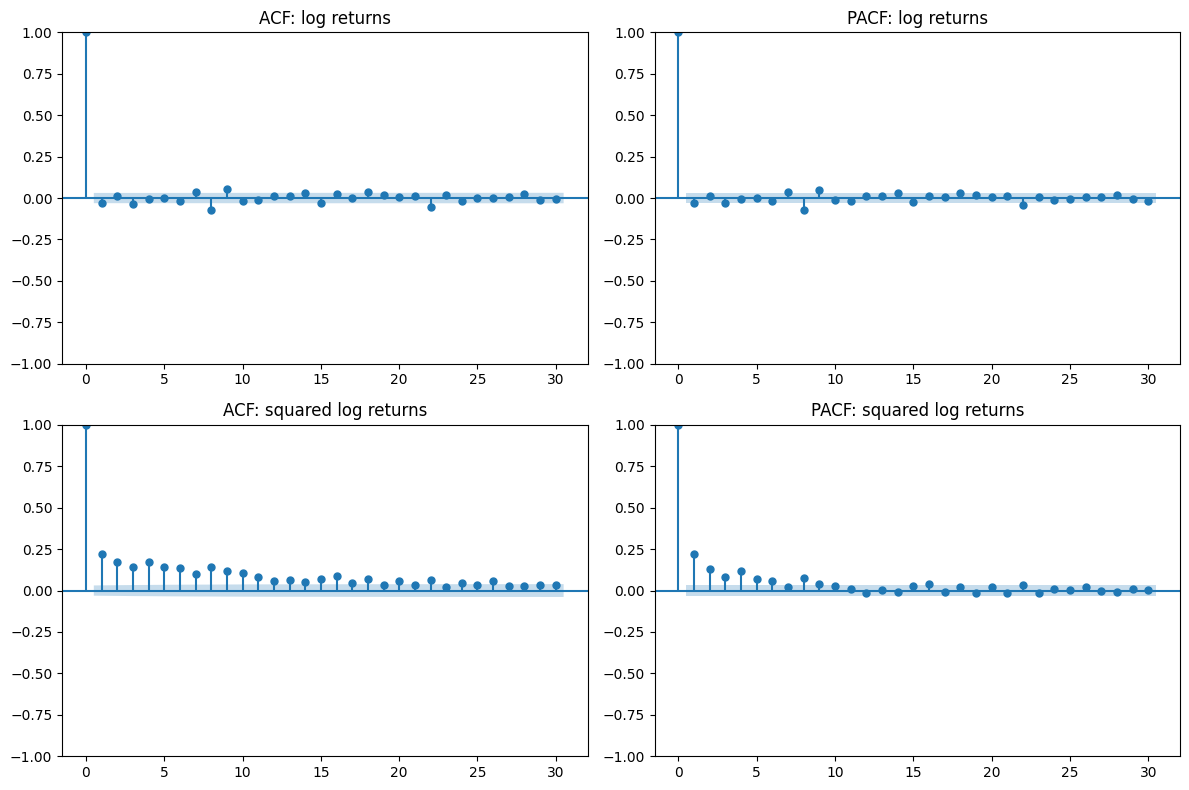

Ljung-Box test — log returns


,lb_stat,lb_pvalue
10,51.159902,1.631690e-07
20,69.454091,2.235718e-07


Ljung-Box test — squared log returns


,lb_stat,lb_pvalue
10,903.321798,1.227601e-187
20,1070.816238,3.026623e-214


ARCH LM test statistic: 401.62
ARCH LM p-value:       0.0000


In [21]:
ret = df["log_ret"]
ret_sq = ret ** 2

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(ret, lags=30, ax=axes[0, 0])
axes[0, 0].set_title("ACF: log returns")

plot_pacf(ret, lags=30, ax=axes[0, 1], method="ywm")
axes[0, 1].set_title("PACF: log returns")

plot_acf(ret_sq, lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF: squared log returns")

plot_pacf(ret_sq, lags=30, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title("PACF: squared log returns")

plt.tight_layout()
plt.show()

lb_ret = acorr_ljungbox(ret, lags=[10, 20], return_df=True)
lb_ret_sq = acorr_ljungbox(ret_sq, lags=[10, 20], return_df=True)

print("Ljung-Box test — log returns")
display(lb_ret)

print("Ljung-Box test — squared log returns")
display(lb_ret_sq)

arch_lm_stat, arch_lm_pvalue, _, _ = het_arch(ret)

print(f"ARCH LM test statistic: {arch_lm_stat:.2f}")
print(f"ARCH LM p-value:       {arch_lm_pvalue:.4f}")

In [9]:
y = df["log_ret"]

garch_norm = arch_model(
    y,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="normal"
)

res_norm = garch_norm.fit(disp="off")

garch_t = arch_model(
    y,
    mean="Constant",
    vol="GARCH",
    p=1,
    q=1,
    dist="t"
)

res_t = garch_t.fit(disp="off")

comparison = pd.DataFrame(
    {
        "LogLik": [res_norm.loglikelihood, res_t.loglikelihood],
        "AIC": [res_norm.aic, res_t.aic],
        "BIC": [res_norm.bic, res_t.bic],
        "alpha+beta": [
            res_norm.params["alpha[1]"] + res_norm.params["beta[1]"],
            res_t.params["alpha[1]"] + res_t.params["beta[1]"],
        ],
    },
    index=["GARCH-Normal", "GARCH-t"]
)

print("=== Model comparison ===")
display(comparison)

print("\n=== GARCH(1,1) Normal ===")
print(res_norm.summary())

print("\n=== GARCH(1,1) Student-t ===")
print(res_t.summary())


=== Model comparison ===


,LogLik,AIC,BIC,alpha+beta
GARCH-Normal,-7682.041360,15372.082720,15397.271897,0.947727
GARCH-t,-7485.018716,14980.037433,15011.523905,0.968514



=== GARCH(1,1) Normal ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7682.04
Distribution:                  Normal   AIC:                           15372.1
Method:            Maximum Likelihood   BIC:                           15397.3
                                        No. Observations:                 4013
Date:                Wed, Dec 17 2025   Df Residuals:                     4012
Time:                        14:31:56   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1580  2.610e-02      6.052

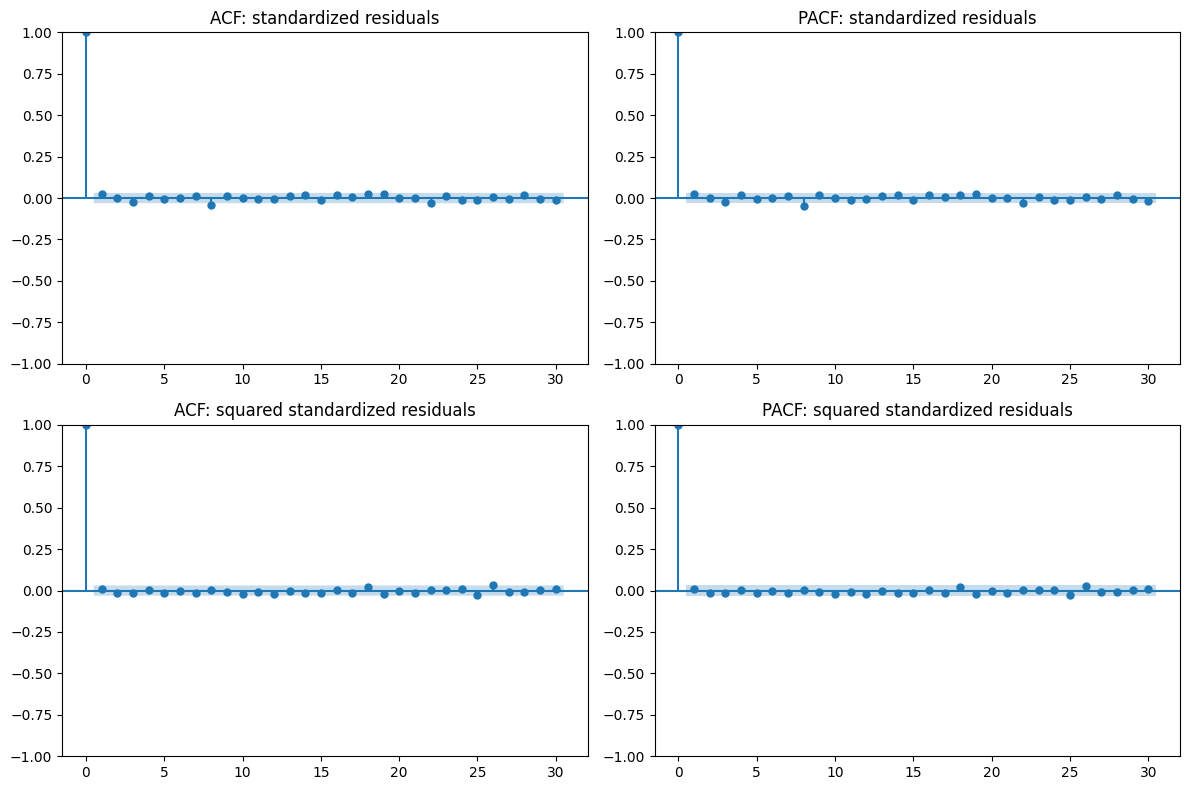

Ljung-Box — standardized residuals


,lb_stat,lb_pvalue
10,14.69069,0.143752
20,24.05254,0.240105


Ljung-Box — squared standardized residuals


,lb_stat,lb_pvalue
10,5.303088,0.870034
20,12.525432,0.896805


ARCH LM statistic (post-GARCH): 5.30
ARCH LM p-value (post-GARCH):   0.8701
Jarque–Bera stat: 1944.57
Jarque–Bera p-value: 0.0000


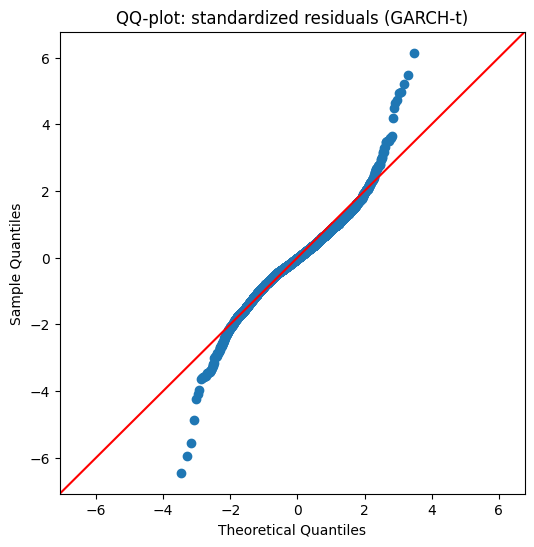

In [10]:
std_resid = res_t.std_resid
std_resid_sq = std_resid ** 2

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(std_resid, lags=30, ax=axes[0, 0])
axes[0, 0].set_title("ACF: standardized residuals")

plot_pacf(std_resid, lags=30, ax=axes[0, 1], method="ywm")
axes[0, 1].set_title("PACF: standardized residuals")

plot_acf(std_resid_sq, lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF: squared standardized residuals")

plot_pacf(std_resid_sq, lags=30, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title("PACF: squared standardized residuals")

plt.tight_layout()
plt.show()

lb_std = acorr_ljungbox(std_resid, lags=[10, 20], return_df=True)
lb_std_sq = acorr_ljungbox(std_resid_sq, lags=[10, 20], return_df=True)

print("Ljung-Box — standardized residuals")
display(lb_std)

print("Ljung-Box — squared standardized residuals")
display(lb_std_sq)

arch_lm_stat, arch_lm_pvalue, _, _ = het_arch(std_resid)

print(f"ARCH LM statistic (post-GARCH): {arch_lm_stat:.2f}")
print(f"ARCH LM p-value (post-GARCH):   {arch_lm_pvalue:.4f}")

jb_stat, jb_pvalue = jarque_bera(std_resid)

print(f"Jarque–Bera stat: {jb_stat:.2f}")
print(f"Jarque–Bera p-value: {jb_pvalue:.4f}")

fig, ax = plt.subplots(figsize=(6, 6))
from statsmodels.graphics.gofplots import qqplot
qqplot(std_resid, line="45", ax=ax)
ax.set_title("QQ-plot: standardized residuals (GARCH-t)")
plt.show()


In [17]:

WINDOW = 21
SCALE = 100 ** 2

log_open = np.log(df["Open"])
log_high = np.log(df["High"])
log_low = np.log(df["Low"])
log_close = np.log(df["Close"])
log_prev_close = log_close.shift(1)

df["Parkinson_RV"] = (
    (1 / (4 * np.log(2))) * (log_high - log_low) ** 2
).rolling(WINDOW).sum() * SCALE

df["GarmanKlass_RV"] = (
    0.5 * (log_high - log_low) ** 2
    - (2 * np.log(2) - 1) * (log_close - log_open) ** 2
).rolling(WINDOW).sum() * SCALE

df["RogersSatchell_RV"] = (
    (log_high - log_open) * (log_high - log_close)
    + (log_low - log_open) * (log_low - log_close)
).rolling(WINDOW).sum() * SCALE

k = 0.34 / (1.34 + (WINDOW + 1) / (WINDOW - 1))

overnight = log_open - log_prev_close
open_close = log_close - log_open

df["YangZhang_RV"] = (
    overnight.pow(2)
    + k * open_close.pow(2)
    + (1 - k) * (
        (log_high - log_open) * (log_high - log_close)
        + (log_low - log_open) * (log_low - log_close)
    )
).rolling(WINDOW).sum() * SCALE


In [20]:
WINDOW = 21
ret = df["log_ret"]

df["RV"] = ret.pow(2).rolling(WINDOW).sum()

df["BV"] = (
    (np.pi / 2)
    * ret.abs().shift(1)
    * ret.abs()
).rolling(WINDOW).sum()

def min_rv(x):
    return (np.pi / (np.pi - 2)) * np.mean(np.minimum(x[:-1]**2, x[1:]**2))

df["MinRV"] = ret.rolling(WINDOW).apply(min_rv, raw=True)

def med_rv(x):
    return (np.pi / (6 - 4 * np.sqrt(3) + np.pi)) * np.median(x**2)

df["MedRV"] = ret.rolling(WINDOW).apply(med_rv, raw=True)


In [19]:
rv_measures = [
    "RV", "BV", "MinRV", "MedRV",
    "Parkinson_RV", "GarmanKlass_RV",
    "RogersSatchell_RV", "YangZhang_RV"
]

results = []

for rv in rv_measures:
    tmp = df[[rv, "GARCH_var_21d"]].dropna()

    y = tmp[rv]
    X = add_constant(tmp["GARCH_var_21d"])

    model = OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    wald = model.wald_test("const = 0, GARCH_var_21d = 1")

    results.append({
        "RV_measure": rv,
        "alpha": model.params["const"],
        "beta": model.params["GARCH_var_21d"],
        "R2": model.rsquared,
        "Wald_pvalue": float(wald.pvalue),
    })

mz_results = pd.DataFrame(results).set_index("RV_measure")
mz_results

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/usr/local

,alpha,beta,R2,Wald_pvalue
RV_measure,,,,
RV,-22.757226,1.291636,0.788807,1.751914e-11
BV,-27.644642,1.294320,0.752007,2.711942e-31
MinRV,-1.522650,0.062745,0.639022,0.000000e+00
MedRV,-0.491001,0.031697,0.610409,0.000000e+00
Parkinson_RV,4.210587,0.544163,0.513846,5.322054e-164
GarmanKlass_RV,4.289067,0.547856,0.435869,2.222768e-110
RogersSatchell_RV,2.777105,0.588652,0.324295,1.274070e-53
YangZhang_RV,-14.947534,1.261226,0.584137,1.437344e-01


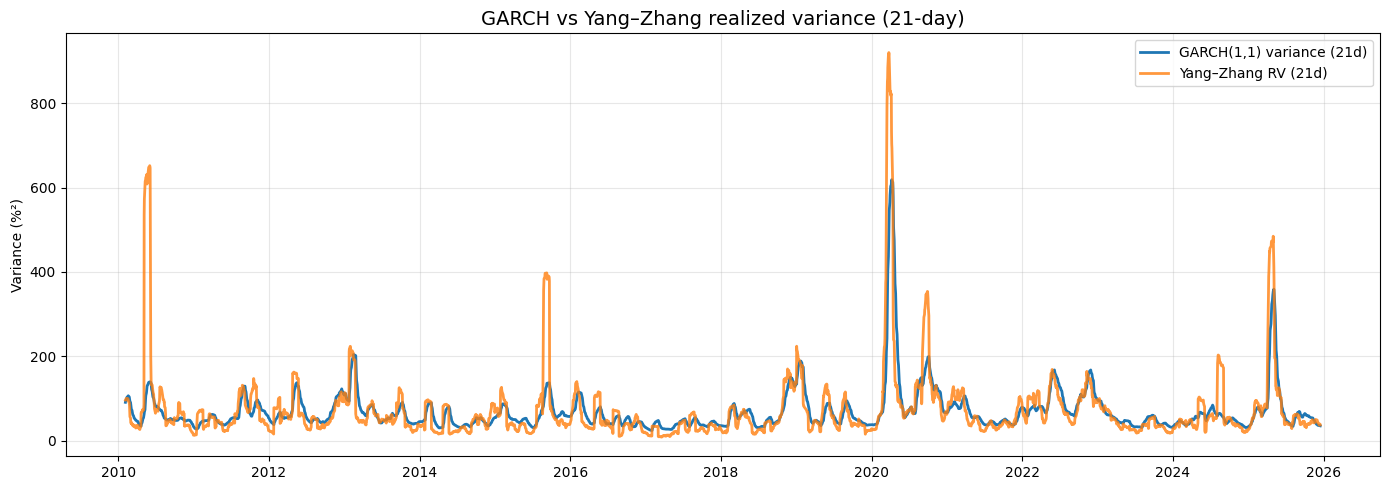

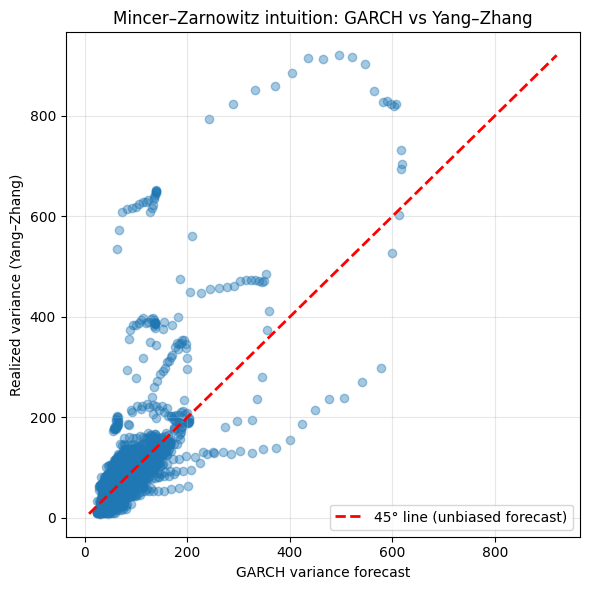

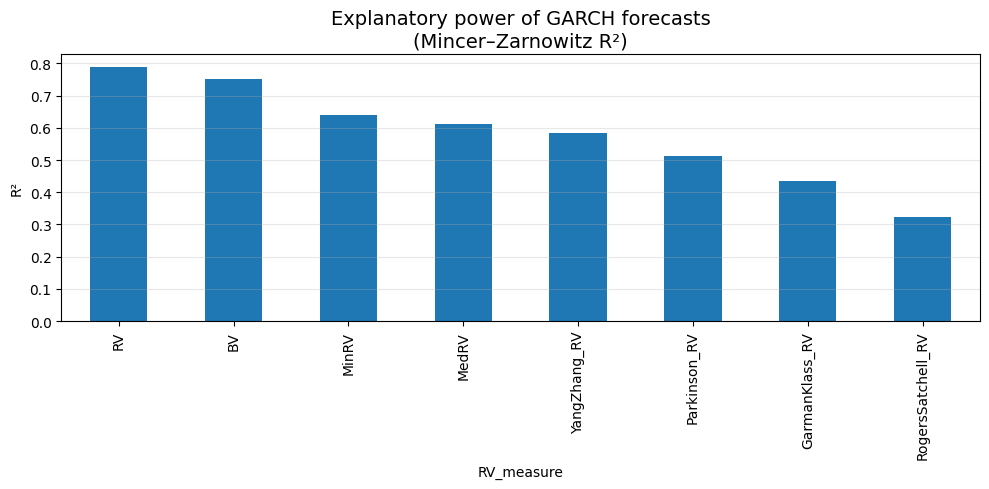

In [23]:
viz_df = df[["GARCH_var_21d", "YangZhang_RV"]].dropna()

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(viz_df.index, viz_df["GARCH_var_21d"], label="GARCH(1,1) variance (21d)", lw=2)
ax.plot(viz_df.index, viz_df["YangZhang_RV"], label="Yang–Zhang RV (21d)", lw=2, alpha=0.8)

ax.set_title("GARCH vs Yang–Zhang realized variance (21-day)", fontsize=14)
ax.set_ylabel("Variance (%²)")
ax.legend()
ax.grid(alpha=0.3)

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    viz_df["GARCH_var_21d"],
    viz_df["YangZhang_RV"],
    alpha=0.4
)

lims = [
    min(viz_df.min()),
    max(viz_df.max())
]
ax.plot(lims, lims, "r--", lw=2, label="45° line (unbiased forecast)")

ax.set_xlabel("GARCH variance forecast")
ax.set_ylabel("Realized variance (Yang–Zhang)")
ax.set_title("Mincer–Zarnowitz intuition: GARCH vs Yang–Zhang")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 5))

mz_results["R2"].sort_values(ascending=False).plot(
    kind="bar",
    ax=ax
)

ax.set_title("Explanatory power of GARCH forecasts\n(Mincer–Zarnowitz R²)", fontsize=14)
ax.set_ylabel("R²")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()